# Исследовательский проект. Выбор локации для скважины

### Цель проекта: по результатам оценки исходных данных о характеристиках трех регионов выбрать один регион, при разработке которого вероятнее всего будет получена наибольшая средняя прибыль.

### Заданный алгоритм оценки:
В каждом регионе исследуется по 500 скважин методом Bootstrep. Внутри каждой группы (пятисотки): 
1. Из 500 скважин при помощи МЛ (методом линейной регрессии) выбирается 200 лучших для разработки 
2. Для каждой из отобранных скважин рассчитывается доход (450 000 * кол-во баррелей в скважине)
3. Рассчитывается суммарный доход (200*поскважинный доход)
4. Расчитывается операционная прибыль(суммарный доход - бюджет на разработку)
5. Оценивается полученное расспределение оценки предполагаемой операционной прибыли.Оценивается вероятность отрицательной операционной прибыли (квантили, pvalue)
6. Принимается решение о том, целессобразно ли исследовать данный региона (если Вероятность убытка < 2.5%)
7. Среди оставшихся регионов проводится сравнение оценок средних значений прибыли. 
8. Выбирается лучший регион. 

### Этапы проекта (задачи)
1. Загрузка библиотек и объявление глобальных переменных
2. Загрузка данных
3. Предъобработка данных
4. Исследование данных
5. Подготовка даныых для МЛ
   - разбиение на на обучающую и валидационную выборки в соотношении 75:25
   - кодирование (при необходимости)
   - масштабирование 
6. Подготовка модели для отбора оптимальных скважин (2 выборки)
    - обучение модели на тренировочной выборке, поиск оптимальных гиперпараметров
    - расчет среднего запаса сырья на валидационной выборке
7. Подготовка к расчету прибыли:
    - определение констант и ключевых параметров
    - расчет минимального среднего запаса сырья,при котором разработка регионане будет убыточной
    - сравнение минимального среднего запаса сырья спредсказанным среднимзапасов порегионам
8.  Оценке прибыли техникой Bootstrep (1000 циклов). В каждом цикле обрабатывается выборка из 500 записей, для которых:
   - выбор 200 лучших для разработки скважин 
   - расчет прибыли (450 000 * предсказанное моделью кол-во баррелей в скважине) для каждой из отобранных скважин 
   - расчет суммарного дохода по региону (200*поскважинный доход)
   - изучение полученного расспределения оценки предполагаемой операционной прибыли
   - определение доверительного интервала
   - расчет вероятности отрицательной операционной прибыли
   - принятие решения о целесообразности исследования региона (если вероятность убытка < 2.5%)

9. Сравнение оценок средних значений прибыли среди актуальных регионов. Выбор лучшего региона. 
10. Выводы.

### Описание исходных данных (далее - ИД)
Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv. Скачать датасет
- /datasets/geo_data_1.csv. Скачать датасет
- /datasets/geo_data_2.csv. Скачать датасет

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).   

## Загрузка библиотек и объявление глобальных переменных

In [1]:
import pandas as pd
import math
import numpy as np
from scipy.stats import kstest, norm, ttest_ind, ttest_1samp
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Определение функций

In [ ]:
#Функция для расчета прибыли
def calc_profit(store_oil, oil_cost, number_of_hole, number_of_seens, iters):
    pred_profit = []
    real_profit = []
    for idx in range(iters):
        #Случайным образом выбираем из записей о запасах нефти 500 строк
        oil_sample = store_oil.sample(n = number_of_seens, random_state = state, replace = False)
        #Предсказанные наиболее "заполненные" скважины
        good_index = oil_sample['prediction'].sort_values(ascending = False).head(number_of_hole).index
        #Реальная операционная прибыль от скважин
        real_profit.append(oil_sample.loc[good_index, 'test_target'].sum()*oil_cost - expenses)
    return real_profit

## Задание констант

In [3]:
state = np.random.RandomState(12345)
param_list = ["f0", "f1", "f2"]

## Загрузка данных

In [4]:
# Считываем данные
geo_data_0 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/geo_data_0.csv")
geo_data_1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/geo_data_1.csv")
geo_data_2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/geo_data_2.csv")

In [5]:
#Словарь для хранения объектов и моделей
dict_keys = [
    "data",                #ДФ с даными по региону
    "features",            #ДФ с признаками 
    "target",              #Сериес с целевым признаком
    "fe_train",            #ДФ с признаками (тренировочная выборка)
    "ta_train",            #Сериес с целевым признаком (тренировочная выборка)
    "fe_test",             #ДФ с признаками (тестовая выборка)
    "ta_test",             #Сериес с целевым признаком (тестовая выборка)
    "scaler",              #объект масштабатора
    "model",               #объект модели
    "pred_train",          #np.array с предсказанием на тренировочной выборке
    "pred_test",           #np.array с предсказанием на тестовой выборке
    "model_params",        #гиперпараметры модели
    "target_and_pred",     #ДФ с предсказанием и целевым признаком (тестовая выборка)
    "pred_profit",         #Сериес с прибылью по предсказанию на тестовой выборке
    "real_profit",         #Сериес с прибылью по целевому признаку на тестовой выборке
]

#Формируем пустой словарь 
regions_dict = { idx: {key: None for key in dict_keys} for idx in range(3)}

#Записываем данные в словарь для автоматизации повторений
regions_dict[0]["data"] = geo_data_0
regions_dict[1]["data"] = geo_data_1
regions_dict[2]["data"] = geo_data_2

In [6]:
for region in regions_dict.values():
    display(region["data"].head(5))
    display(region["data"].info())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Все три предствавленных датасета имеют одинаковую фору (5 столбцов на 10000 записей). В датасетах нет пропусков и нулевых значений. Столбцы (f0, f1, f2, id) имеют корректные названия (заголовки) и ожидаемые типы данных. Столбец product имеет название, совпадающее с зарезервированным pandas названием метода (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.product.html). Переименуем его на этапе предъобработки

## Предъобработка данных

In [7]:
for region in regions_dict.values():
    region["data"] = region["data"].rename(columns={"product": "oil"})      

### Проверка на полные дубликаты

In [8]:
for number, region in enumerate(regions_dict.values()):
    print(f'Количество полных дубликатов в ДФ по региону {number}:\
    {region["data"].duplicated().sum()}')

Количество полных дубликатов в ДФ по региону 0:    0
Количество полных дубликатов в ДФ по региону 1:    0
Количество полных дубликатов в ДФ по региону 2:    0


### Проверка на неполные дубликаты
В данном ДФ целесообразно проверятьтолько столбец id, так как заявлено, что этоуникальный идентификатор скважины

In [9]:
for number, region in enumerate(regions_dict.values()):
    print(f'Количество полных дубликатов в ДФ по региону {number}: \
    {region["data"].duplicated(subset = ["id"]).sum()}')


Количество полных дубликатов в ДФ по региону 0:     10
Количество полных дубликатов в ДФ по региону 1:     4
Количество полных дубликатов в ДФ по региону 2:     4


Во всех ДФ обнаружены дубликаты id, которых с учетом полученного ТЗ быть не должно. Выведем их на экран и посмотрим подробнее

In [10]:
for idx, region in enumerate(regions_dict.values()):
    doubles = region["data"].loc[region["data"].duplicated(subset = ['id'])].id
    print(f"Дублирующие записи для {idx}-го региона")
    for double in doubles:
        display(region["data"].query("id == @double"))

Дублирующие записи для 0-го региона


,id,f0,f1,f2,oil
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


,id,f0,f1,f2,oil
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798


,id,f0,f1,f2,oil
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


,id,f0,f1,f2,oil
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


,id,f0,f1,f2,oil
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


,id,f0,f1,f2,oil
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453


,id,f0,f1,f2,oil
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


,id,f0,f1,f2,oil
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


,id,f0,f1,f2,oil
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


,id,f0,f1,f2,oil
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


Дублирующие записи для 1-го региона


,id,f0,f1,f2,oil
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


,id,f0,f1,f2,oil
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886


,id,f0,f1,f2,oil
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


,id,f0,f1,f2,oil
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


Дублирующие записи для 2-го региона


,id,f0,f1,f2,oil
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


,id,f0,f1,f2,oil
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


,id,f0,f1,f2,oil
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


,id,f0,f1,f2,oil
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


При анализе дублирующих записей не удалось выявить каких-либо закономерностей. Не понятно, связаны ли дубликаты между собой (то есть, дубликаты - это записи об одной и той же скважине, например уточненные со временем или данные о разных скважинах, у которых случайно при обезличивании совпали идентификаторы.) С учетом того, что в названиях id использованы английские буквы в разных раскладках и цифры (всего 62 символа), а длина комбинации - 5 символов, символы в комбинации могут повторяться, то число возможных комбинаций равно: n!/(k!*(n-k)!).

In [11]:
print(f'Вероятномсть одного совпадения сгенерированных значений id в одном ДФ равна\
{(100000/(math.factorial(62)/(math.factorial(5)*math.factorial(62-5))))**2:.04%}')


Вероятномсть одного совпадения сгенерированных значений id в одном ДФ равна0.0239%


Вероятность одного повторения крайне мала, вероятность же появления в ДФ нескольких повторов будет еще меньше, что переводит указанные события в категорию практически невозможных. Значит мы можем предположить, что появление повторений не случайно и связано:
- с ошибкой пользователей (скопировали, списали не правильно id)
- c плохим алгоритмом генерации случайных комбинаций (но тогда повторов ожидаемо было бы намного больше)
- некорректным изменением парметров скважины, при котором появились дуюлирующие записи.

Из предложенных вариантов, два наиболее вероятных связаны с ошибками записи данных в ДФ. Поэтому чтобы исключить влияние ошибок на оценки исследования следует удалить все повторяющиеся записи,тем более, что их много меньше 10% ДФ

In [12]:
#Исключаем записи с повторяющимися id
for number, region in enumerate(regions_dict.values()):
    region["data"].drop_duplicates(subset = ['id'], inplace = True, ignore_index = True)
    print(f'Количество неполных дубликатов в ДФ {number}-го региона:\
    {region["data"].duplicated(subset = ["id"]).sum()}')


Количество неполных дубликатов в ДФ 0-го региона:    0
Количество неполных дубликатов в ДФ 1-го региона:    0
Количество неполных дубликатов в ДФ 2-го региона:    0


### Изучение данных

Про столбцы в ТЗ сказано, что это некие данные, значения которых не должны обсуждаться. Посмотри, как они распределены. 

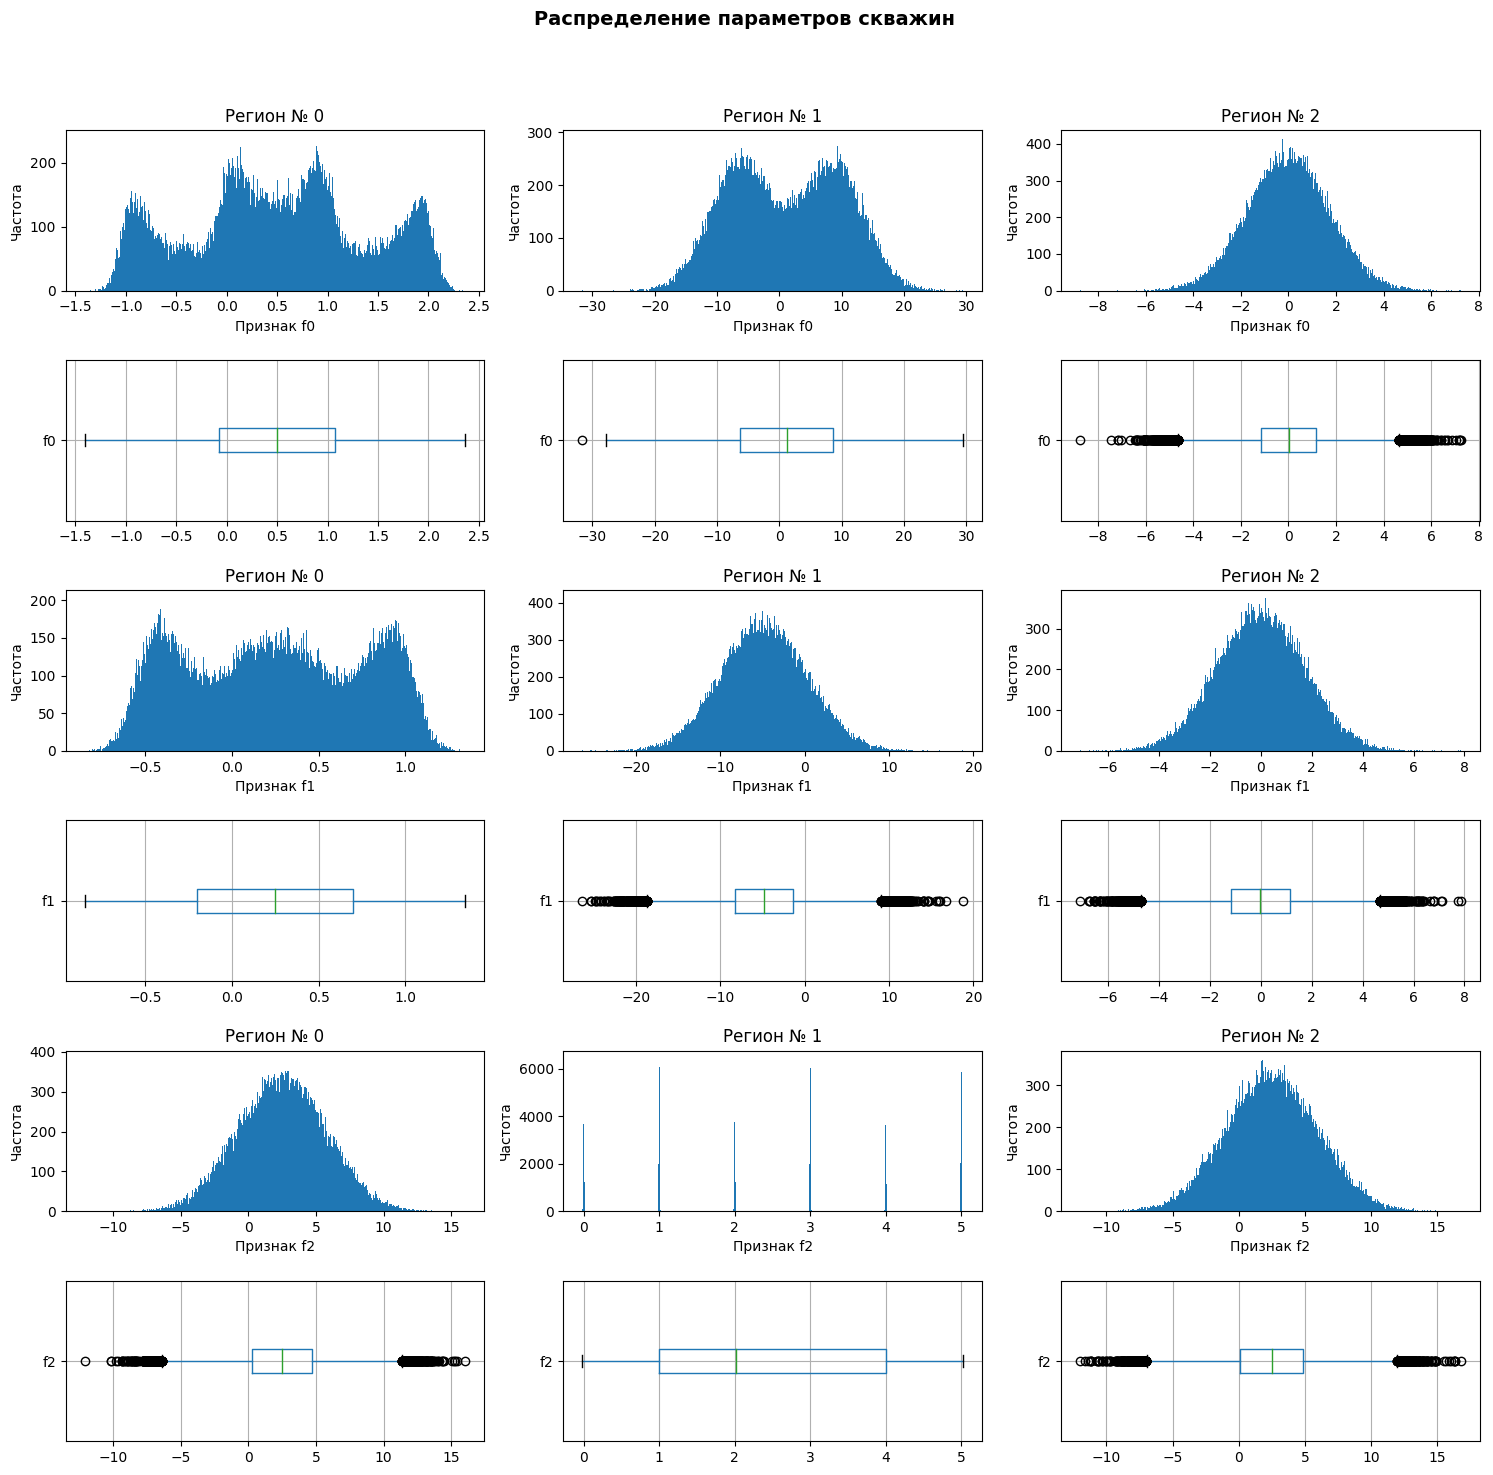

In [13]:
#Выводим на график распределения параметров для каждого региона
fig, axes = plt.subplots(nrows=6, ncols=3, sharey=False, figsize=(15, 15))
# Заголовок фигуры
fig.suptitle('Распределение параметров скважин', fontsize=14, fontweight='bold');
for idy, param in enumerate(param_list):
    for idx, region in enumerate(regions_dict.values()):
        region["data"].plot(kind = 'hist', y = param, bins = 1000, ax = axes[2*idy][idx])
        region["data"].boxplot(column = [param], vert=False, ax = axes[2*idy + 1][idx])
        
        axes[2*idy][idx].set_xlabel(f'Признак {param}')
        axes[2*idy][idx].set_ylabel('Частота');
        axes[2*idy][idx].set(title = f"Регион № {idx}")
        axes[2*idy][idx].legend().set_visible(False)

#Определяем расстояние между заголовками графиков
fig. tight_layout (h_pad= 2)
#Определяем отступ для основного заголовка
plt.subplots_adjust(top= 0.90)

По гистограммам и ящикам с усами видно, что:
1. В разных регионах распределение признаков имеет абсолютно разную форму
2. Форма распределения признака f0 внешне выглядит нормальной только во втором регионе
3. Форма распределения признака f1 внешне выглядит нормальной в первом и втором регионе
3. Форма распределения признака f3 внешне выглядит нормальной в нулевом и втором регионе
4.Там, где форма распределения похожа на нормальную, отмечается наличие кучных выбросов. Судя по кучности они не являются аномальными и не подлежат удалению.

Параметры f0, f1, f2 - это признаки на основании которых будет вычисляться целевой признак. Чтобы исключить ухудшение качества машинных моделей, проверим степень корреляции между ними в разных регионах.

<ipython-input-14-258b30802754>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(region["data"].corr(), ax = axes[idx])


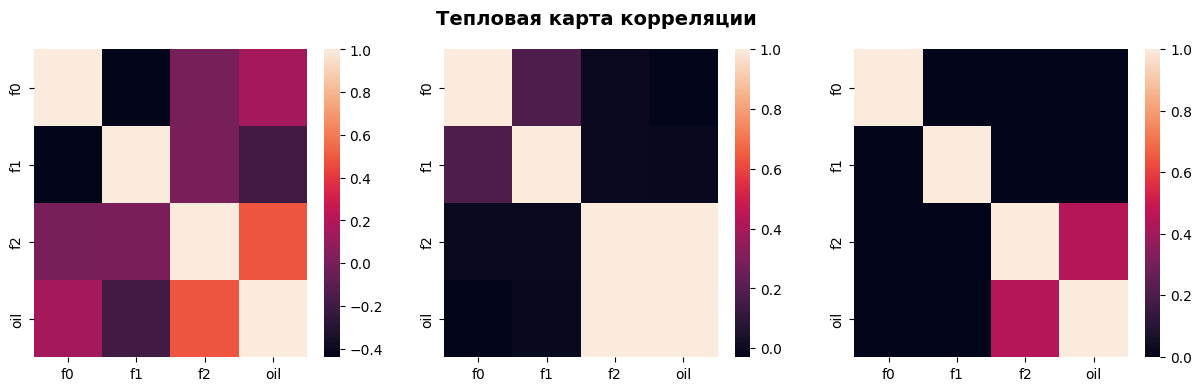

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey = False, figsize = (15, 4))
# Заголовок фигуры
fig.suptitle('Тепловая карта корреляции', fontsize=14, fontweight='bold');
for idx, region in enumerate(regions_dict.values()):
    sns.heatmap(region["data"].corr(), ax = axes[idx])

По тепловым картам видно, что:
1. Взаимная корреляция признаков f0, f1, f3 во всех регионах находится в диапазоне (-0.2- 0.2 ).
2. Во всех регионах наиболее сильная зависимость наблюдаеся между запасами нефти и признаком f2. В первом регионе коэффицент связи стремится к 1.

Так взаимное влияние признаков f0, f1, f3 отсутствует, оставляем их все без модификации ДФ. Рассмотрим данные о запазах нефти (целевой признак).

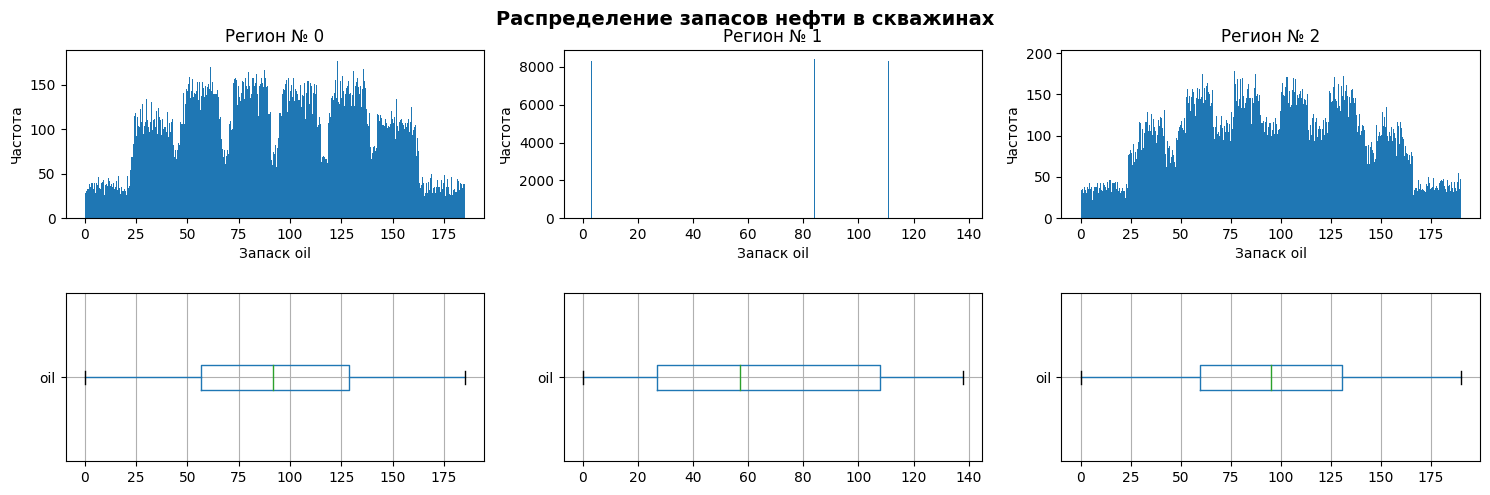

In [15]:
#Выводим на график распределения запасов нефти для каждого региона
oil_list = ["oil"]
fig, axes = plt.subplots(nrows = 2, ncols = 3, sharey = False, figsize = (15, 5))
# Заголовок фигуры
fig.suptitle('Распределение запасов нефти в скважинах', fontsize=14, fontweight='bold');
for idy, param in enumerate(oil_list):
    for idx, region in enumerate(regions_dict.values()):
        region["data"].plot(kind = 'hist', y = param, bins = 1000, ax = axes[2*idy][idx])
        region["data"].boxplot(column = [param], vert=False, ax = axes[2*idy + 1][idx])
        
        axes[2*idy][idx].set_xlabel(f'Запаск {param}')
        axes[2*idy][idx].set_ylabel('Частота');
        axes[2*idy][idx].set(title = f"Регион № {idx}")
        axes[2*idy][idx].legend().set_visible(False)

#Определяем расстояние между заголовками графиков
fig. tight_layout (h_pad= 2)
#Определяем отступ для основного заголовка
plt.subplots_adjust(top= 0.90)

Распределение запасов нефти для нулевого и третьего регионов имеют близкую форму, которя по параметрам не может быть отесена ни к одному из часто используемых распределений. Больше всего она напоминает 6 наложенных друг на друга нормальных распределений. Вид распределения в первом регионе координально отличается. Данные этого региона выглядят слишком синтетическими, все возможные значения запасов нефти принимают одно из 4(!) возможных значений. В реальной жизни такая точность крайне маловероятна.
Вместе с тем выбросов среди значений запасов не выявлено.

Запас нефти - это целевой признак. Оставляем его в ДФ без модификаций.

## Подготовка даныых для машинного обучения
- разбиение на на обучающую и валидационную выборки в соотношении 75:25
- масштабирование 

In [16]:
#Выкидываем столбец с неинформативными признаками - id
for region in regions_dict.values():
    region["data"] = region["data"].drop(columns = ['id'], axis = 1)

### Разобиение данных на выборки

In [17]:
#Выделяем признаки и целевой признак
for number, region in regions_dict.items():
    region["target"] = region["data"].oil
    region["features"] = region["data"].drop(columns = ['oil'], axis = 1)
    print(f'Форма созданных массивов в регионе {number}: признаки {region["features"].shape}, целевой признак {region["target"].shape}')


Форма созданных массивов в регионе 0: признаки (99990, 3), целевой признак (99990,)
Форма созданных массивов в регионе 1: признаки (99996, 3), целевой признак (99996,)
Форма созданных массивов в регионе 2: признаки (99996, 3), целевой признак (99996,)


In [18]:
#Делим выборку на тренировочную и тестовую
for number, region in regions_dict.items():
    region["fe_train"], region["fe_test"], region["ta_train"], region["ta_test"] = \
    train_test_split( region["features"], region["target"], test_size=0.25, random_state = state)
    print(f'''Форма созданных массивов в регионе {number}: 
    тренировочнные:  признаки {region["fe_train"].shape}, целевой признак {region["ta_train"].shape}
    тестовые:  признаки {region["fe_test"].shape}, целевой признак {region["ta_test"].shape}
    ''')


Форма созданных массивов в регионе 0: 
    тренировочнные:  признаки (74992, 3), целевой признак (74992,)
    тестовые:  признаки (24998, 3), целевой признак (24998,)
    
Форма созданных массивов в регионе 1: 
    тренировочнные:  признаки (74997, 3), целевой признак (74997,)
    тестовые:  признаки (24999, 3), целевой признак (24999,)
    
Форма созданных массивов в регионе 2: 
    тренировочнные:  признаки (74997, 3), целевой признак (74997,)
    тестовые:  признаки (24999, 3), целевой признак (24999,)
    


### Масштабирование данных

Существует два подхода кмасштабированию: нормализация и стандартизация. Будем использовать стандартизацию, так как она позволяет обрабатывать выбросы в данных, которые появляются после масштабирования. 

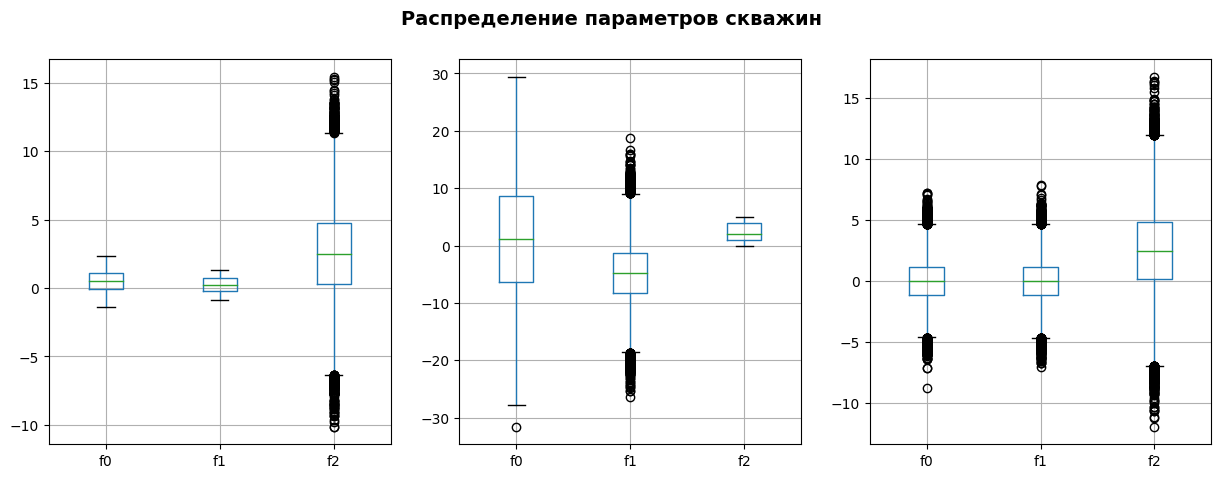

In [19]:
#Фиксируем графики параметров до масштабирования
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(15, 5))
# Заголовок фигуры
fig.suptitle('Распределение параметров скважин', fontsize=14, fontweight='bold');
for idx, region in enumerate(regions_dict.values()):
    region['fe_train'].boxplot(column = param_list, ax = axes[idx])

In [20]:
for number, region in regions_dict.items():
    #Формируем объект масштабатора
    region["scaler"] = StandardScaler()
    
    #Обучаем масштабатор на тренировочных выборках 
    region["scaler"].fit(region["fe_train"])
    
    #Масштабируем данные
    region["fe_train"] = pd.DataFrame(region["scaler"].transform(region["fe_train"]), columns = param_list)

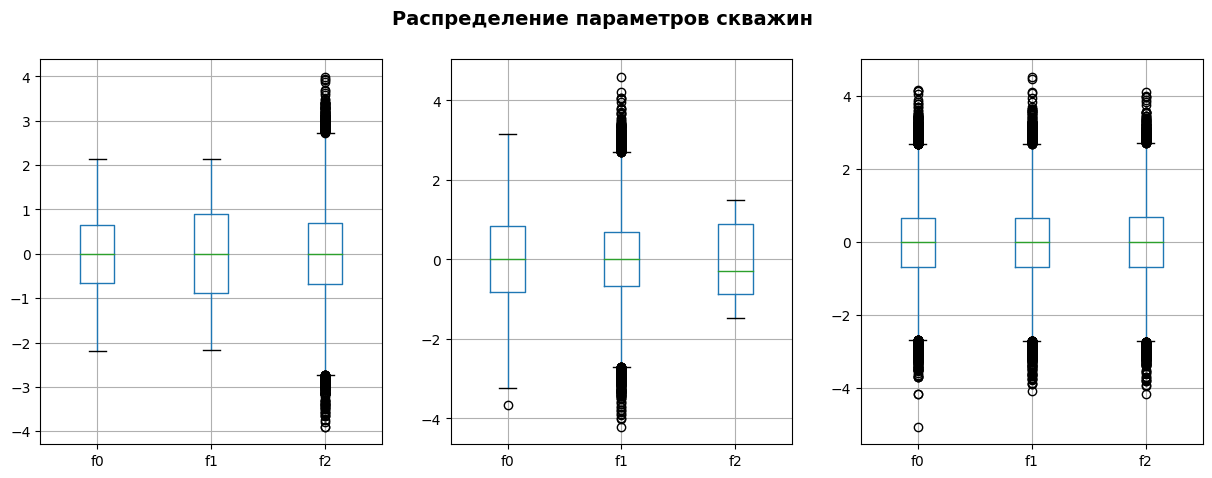

In [21]:
#Фиксируем графики параметров после масштабирования
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(15, 5))
# Заголовок фигуры
fig.suptitle('Распределение параметров скважин', fontsize=14, fontweight='bold');
for idx, region in enumerate(regions_dict.values()):
    region['fe_train'].boxplot(column = param_list, ax = axes[idx])



## Обучение и проверка модели

### Подготовка модели для отбора оптимальных скважин (2 выборки)
   - обучение модели на тренировочной выборке, поиск оптимальных гиперпараметров
   - расчет среднего запаса нефти на валидационной выборке

In [22]:
#Модели линейной регрессии
for number, region in regions_dict.items():
    #Формируем модель
    region["model"] = LinearRegression()
    
    #Обучаем модель 
    region["model"].fit(region["fe_train"], region["ta_train"])
    
    #Масштабируем тестовые данные
    region["fe_test"] = pd.DataFrame(region["scaler"].transform(region["fe_test"]), columns = param_list)
    
    #Определяем качество модели
    region["pred_train"] = region["model"].predict(region["fe_train"])
    region["pred_test"] = pd.Series(data = region["model"].predict(region["fe_test"]), index = region["ta_test"].index)
    
    print(f'''Регион № {number}, train:
MSE = {mean_squared_error(region["ta_train"], region["pred_train"]):.05},\
RMSE = {(mean_squared_error(region["ta_train"], region["pred_train"]))**0.5:.03},\
R^2 = {r2_score(region["ta_train"], region["pred_train"]):.03}''')

    print(f'''Регион № {number}, test:
MSE = {mean_squared_error(region["ta_test"], region["pred_test"]):.05},\
RMSE = {(mean_squared_error(region["ta_test"], region["pred_test"]))**0.5:.03},\
R^2 = {r2_score(region["ta_test"], region["pred_test"]):.05}''')
    
    


Регион № 0, train:
MSE = 1416.7,RMSE = 37.6,R^2 = 0.277
Регион № 0, test:
MSE = 1432.9,RMSE = 37.9,R^2 = 0.27239
Регион № 1, train:
MSE = 0.79021,RMSE = 0.889,R^2 = 1.0
Регион № 1, test:
MSE = 0.80063,RMSE = 0.895,R^2 = 0.99962
Регион № 2, train:
MSE = 1604.8,RMSE = 40.1,R^2 = 0.198
Регион № 2, test:
MSE = 1603.3,RMSE = 40.0,R^2 = 0.20125


Лучше всего показатели модели на первом (среднем) регионе. При этом во всех регионах величина метрики RMSE практически не ухудшается при переходе с тренировочной выборки на тестовую.

Посмотрим как выглядят распределения предсказанных и фактических значений

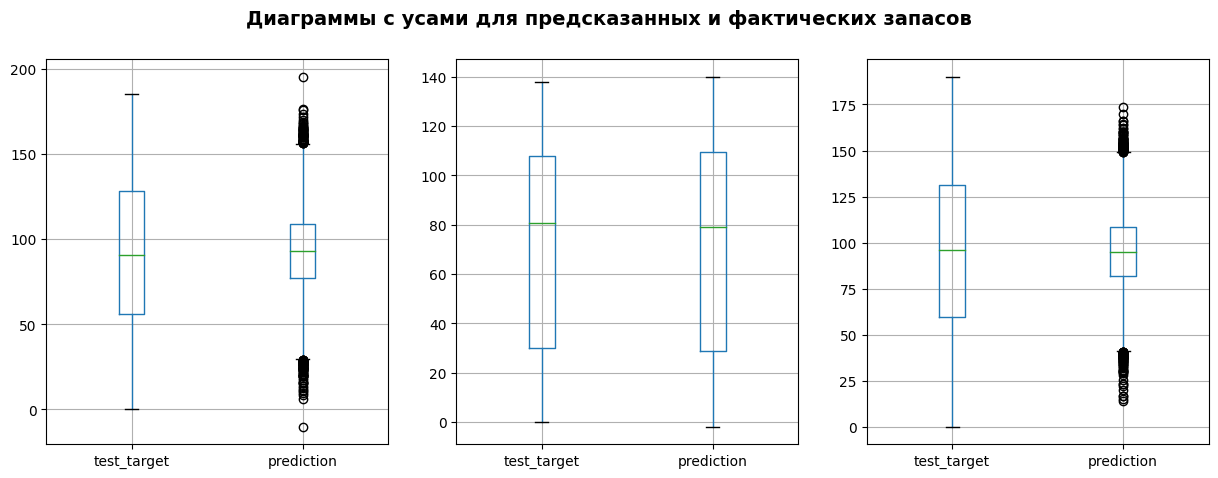

In [23]:
#Диаграммы с усами для предсказанных и фактических запасов
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(15, 5))
# Заголовок фигуры
fig.suptitle('Диаграммы с усами для предсказанных и фактических запасов', fontsize=14, fontweight='bold');
#Объединение реальных и предсказанных значений в одном ДФ
for idx, region in enumerate(regions_dict.values()):
    region["target_and_pred"] = pd.DataFrame(data = {'test_target': region['ta_test'], 'prediction': region['pred_test']},\
                index = region['ta_test'].index)
    region["target_and_pred"].boxplot(ax = axes[idx])   

Более-менее адекватными видятся предсказания в первом регионе. Это было ожидаемо, ведь в этом регионе один из признаков имеет коэффициент корреляции с запасами нефти, равный 1. В нулевом регионе получилось одно отрицательное значение запасов нефти. В нулевом и первом регионах кроме того пространство возможных значений запасов очень сильно сжалось. Кроме того,можно отметить, что:
1. Во всех регионах предсказания не выходят за границы фактических значений (то есть риск того, что предсказание будет намного превышать фактические запасы топлива минимален)
2. Во всех регионах средние значения предсказаний близки к фактическим средним
3. В 0 регионе предсказания самые точные, что объясняется сильной положительной связью признака и целевого признака
4. Во 0 и 2 регионах отмечается значительное количество выбросов, симметричных относительно медианы.

In [24]:
for number, region in enumerate(regions_dict.values()):
    print(f'''В предсказаниях региона {number} выявлено: \
    {region["target_and_pred"].prediction.transform(lambda x: 1 if x < 0 else 0).sum()} отрицательных значений''')


В предсказаниях региона 0 выявлено:     1 отрицательных значений
В предсказаниях региона 1 выявлено:     543 отрицательных значений
В предсказаниях региона 2 выявлено:     0 отрицательных значений


## Подготовка к расчёту прибыли

In [25]:
# Константы для расчетов запасов сырья и прибыли
MILLIARD = 1000000000
oil_cost = 450000
expenses = 10*MILLIARD
number_of_hole = 200
number_of_seens = 500

### Рассчет объёма сырья в одной скважине, достаточного для безубыточной разработки нового региона. 

In [26]:
requred_oil = expenses/(oil_cost*number_of_hole)
print(f'Объём сырья, достаточного для безубыточной разработки региона: {requred_oil:.04} единиц топлива')

Объём сырья, достаточного для безубыточной разработки региона: 111.1 единиц топлива


По результатам оценки получено среднее значение сырья в одной скважине, достаточное для безубыточной разработки нового региона. Это не значит, что в каждой скважине должно быть такое количество сырья. Естественно, что в некоторых скважинах сырья будет меньше, а в других значительно больше. Так, как это проиллюстрировано на диаграммах размаха.

### Сравнение необходимого объёма сырья со средним запасом в каждом регионе.

In [27]:
for number, region in enumerate(regions_dict.values()):
    print(f'Средний объём сырья в регионе {number}: {region["target_and_pred"].prediction.mean()}')
    

Средний объём сырья в регионе 0: 92.78915638280621
Средний объём сырья в регионе 1: 68.95746560835222
Средний объём сырья в регионе 2: 95.07949668343952


По результам сравнения в лоб (основываясь на однократном предсказании модели) получается, что разработка будет убыточна во всех регионах. Но формировать выводы по этим данным нецелесообразно, потому что:
1. они недостаточно надежны (единичный эксперемент - это слишком мало для формулирования статистически значимых выводов)
2. они учитывают все скважины, а по условю задания подлежат разработке только 200 наиболее успешных из 500 рассматриваемых. 

Для создания условий для статистическизначимой оценки
величины запасов сырья в скважинах по региону применим технику bootstrep, эмулирующую многократные эксперименты. При реализации техники Bootstrep учтем условие задания, в соответсвии с которым потенциально в регионе могут "посмотреть" 500 скважин из которых разработке подлежат 200 скважин.

### Оценка прибыли по регионам методом bootstrep

#### Расчет прибыли

In [29]:
#Расчет прибыли
for number, region in enumerate(regions_dict.values()):
    region["real_profit"] =\
    calc_profit(region["target_and_pred"], oil_cost, number_of_hole, number_of_seens, 1000)   
    

#### Расчет доверительного интервала

In [30]:
#Расчет 95% доверительного интервала
for number, region in enumerate(regions_dict.values()):
    region["real_profit"] = pd.Series(region["real_profit"])
    print(f'''Расчетные реальные данные по региону {number}:
    - cредняя операционная прибыль: {region["real_profit"].mean()/MILLIARD} млрд.,
    - верхняя граница 95% интервала: {region["real_profit"].quantile(0.975)/MILLIARD} млрд., 
    - нижняя граница 95% интервала: {region["real_profit"].quantile(0.025)/MILLIARD} млрд.''')   


Расчетные реальные данные по региону 0:
    - cредняя операционная прибыль: 0.3921015936631343 млрд.,
    - верхняя граница 95% интервала: 0.9252057174672367 млрд., 
    - нижняя граница 95% интервала: -0.11412179890033186 млрд.
Расчетные реальные данные по региону 1:
    - cредняя операционная прибыль: 0.44785879914632837 млрд.,
    - верхняя граница 95% интервала: 0.8558177394014543 млрд., 
    - нижняя граница 95% интервала: 0.028158769586531168 млрд.
Расчетные реальные данные по региону 2:
    - cредняя операционная прибыль: 0.44280007130870985 млрд.,
    - верхняя граница 95% интервала: 0.924152918385759 млрд., 
    - нижняя граница 95% интервала: -0.06267475270254252 млрд.


In [31]:
#Расчет риска отрицательной операционой прибыли
for number, region in enumerate(regions_dict.values()):
    print(f'Риск убытков в регионе № {number} равен {(region["real_profit"] < 0).sum()/(1000)}')    

Риск убытков в регионе № 0 равен 0.061
Риск убытков в регионе № 1 равен 0.018
Риск убытков в регионе № 2 равен 0.043


#### Графики распределений

In [32]:
def currency(x, pos):
    'Два аргумента - это значение и позиция отметки.'
    if x >= 1000000000:
        return f'{x/MILLIARD}М'
    return f'{x/1000000}м.'

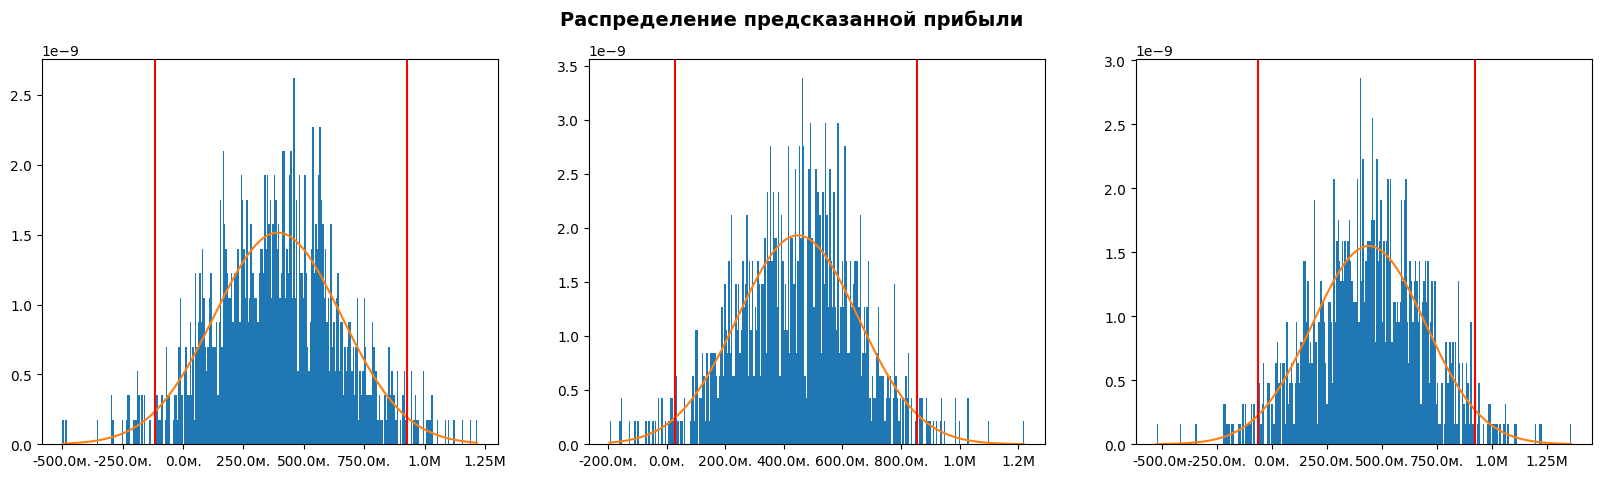

In [33]:
#Ввод графиков распределения оценки прибыли и сравнение их с нормальным распределением
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(20, 5))
# Заголовок фигуры
fig.suptitle('Распределение предсказанной прибыли', fontsize=14, fontweight='bold');
for idx, region in enumerate(regions_dict.values()):
    formatter = FuncFormatter(currency)
    axes[idx].xaxis.set_major_formatter(formatter)
    #Масштабированное распределение прибыли
    axes[idx].hist(region["real_profit"], bins = 300, stacked = True, density = True)
    #Параметры нормального распределения
    std = np.std(region["real_profit"])
    mu = np.mean(region["real_profit"])
    #Нормальное распределение с параметрами распределения прибыли
    x = np.arange (min(region["real_profit"]), max(region["real_profit"]), 100000)
    axes[idx].plot(x, norm.pdf (x, mu, std))
    #Границы 95% интервала
    axes[idx].axvline(x = region["real_profit"].quantile(0.975), ymin=0, ymax=1, color = 'red')
    axes[idx].axvline(x = region["real_profit"].quantile(0.025), ymin=0, ymax=1, color = 'red') 
    

Очевидно 1000 итираций недостаточно чтобы создать нормальное распределение приемлимой формы. Ради эксперемента попробуем увеличить количество итераций в 10 раз

In [34]:
#Расчет прибыли
for number, region in enumerate(regions_dict.values()):
    region["experiment_real_profit"] =\
    calc_profit(region["target_and_pred"], oil_cost, number_of_hole, number_of_seens, 10000)
    region["experiment_real_profit"] = pd.Series(region["experiment_real_profit"])

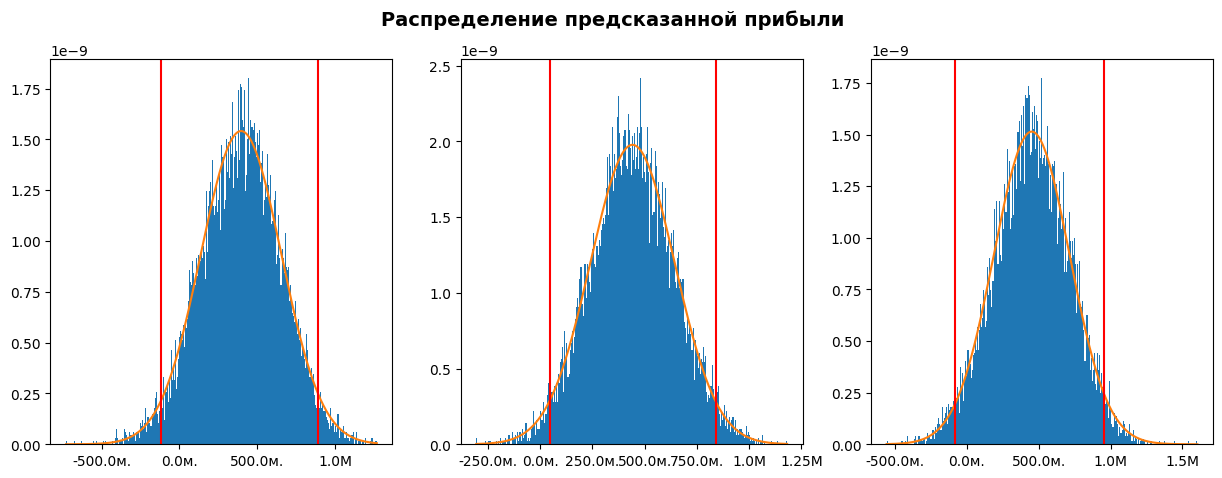

In [35]:
#Ввод графиков распределения оценки прибыли и сравнение их с нормальным распределением
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(15, 5))
# Заголовок фигуры
fig.suptitle('Распределение предсказанной прибыли', fontsize=14, fontweight='bold');
for idx, region in enumerate(regions_dict.values()):
    formatter = FuncFormatter(currency)
    axes[idx].xaxis.set_major_formatter(formatter)
    #Масштабированное распределение прибыли
    axes[idx].hist(region["experiment_real_profit"], bins = 300, stacked = True, density = True)
    #Параметры нормального распределения
    std = np.std(region["experiment_real_profit"])
    mu = np.mean(region["experiment_real_profit"])
    #Нормальное распределение с параметрами распределения прибыли
    x = np.arange (min(region["experiment_real_profit"]), max(region["experiment_real_profit"]), 100000)
    axes[idx].plot(x, norm.pdf (x, mu, std))
    #Границы 95% интервала
    axes[idx].axvline(x = region["experiment_real_profit"].quantile(0.975), ymin=0, ymax=1, color = 'red')
    axes[idx].axvline(x = region["experiment_real_profit"].quantile(0.025), ymin=0, ymax=1, color = 'red') 

На графиках четко видно, что качество распределения (нормальность) существенно улучшилось. Однако далее в расчетах будем использовать распределение, полученные в соттветствии с параметрами, указанными в задании.

#### Расчёт вероятности убытков

In [36]:
for idx, region in enumerate(regions_dict.values()):
    #Параметры нормального распределения
    std = np.std(region["real_profit"])
    mu = np.mean(region["real_profit"])
    #Вероятность убыточной разработки
    print(f'Веротность того, что разработка в регионе будет убыточной равна: {norm(loc = mu , scale = std).cdf(0):.02%}')    

Веротность того, что разработка в регионе будет убыточной равна: 6.83%
Веротность того, что разработка в регионе будет убыточной равна: 1.50%
Веротность того, что разработка в регионе будет убыточной равна: 4.27%


Вероятность убыточной разработки больше всего в нулевом регионе. Она не превышает 2.5 % только в среднем регионе. 

#### Выбор потенциально самого прибыльного региона

In [37]:
#Вывод основных характеристик
for idx, region in enumerate(regions_dict.values()):
    #Параметры нормального распределения
    print(f'''Регион № {idx} 
 мода {region["real_profit"].mean()/MILLIARD:.05}, \
 СТД {np.std(region["real_profit"])/MILLIARD:.05}, \
 предел: {region["real_profit"].quantile(0.025)/MILLIARD:.05},\
 риск убытка: {(region["real_profit"] < 0).sum()/(1000):.02%},\
 риск убытка (стат): {norm(loc = np.mean(region["real_profit"]) , scale = np.std(region["real_profit"])).cdf(0):.04%}''')
    


Регион № 0 
 мода 0.3921,  СТД 0.26339,  предел: -0.11412, риск убытка: 6.10%, риск убытка (стат): 6.8286%
Регион № 1 
 мода 0.44786,  СТД 0.2064,  предел: 0.028159, риск убытка: 1.80%, риск убытка (стат): 1.5007%
Регион № 2 
 мода 0.4428,  СТД 0.25746,  предел: -0.062675, риск убытка: 4.30%, риск убытка (стат): 4.2729%


Выбор перспективного региона однозначен:
1. Среднее значение прибыли больше всего в первом (среднем) регионе, при этом дисперсия в этом регионе самая маленькая, а значит разброс вероятных значений прибыли вокруг среднего также небольшой.Установившийся баланс между большой модой и маленькой дисперсией позволяет занимать региону последнее место по вероятности убытков (менее 1.5 %).
2. В остальных регионах мода распределения ниже, а дисперсия выше, что логичным образом увеличивает шансы возникновения ситуации, когда чистая прибыли по региону будет меньше 10 млрд, а значит разработка региона станет убыточной
3. С учетом изложенного, самым перспективным представляется первый (средний) регион. В нем идеальное соотношение величины моды, дисперсиии и границы доверительного интервала, что позвляет достигать вероятности убытков, меньшей 1.5%

Вместе с тем, стоит отметить, что решение такого масштаба не следует принимать на основании одного исследования.  

## Выводы

Целью исследования было выбрать среди трех регионов один, наиболее перспективный с точки зрения разработки сырья и получения прибыли. Выбор региона необходимо было осуществить на основании полученных ранее характеристик скважин и исторических данных об объемах сырья. 


В процесе исследования:

1. Загружены и изучены данные о скважинах в трех регионах
2. Загруженные данные оценены:
    - определена форма их распределения
    - проверена взаимная корреляция
3. Выполнена предъобработка, включая:
   - переименование названия столбца (с product на oil, так как имя product используется в библиотете pandas)
   - проверку корректноти назначенных типов данных (некорректных назначений не выявлено
   - поиск полных и неявных дубликатов (удалено 30 неявных дубликатов)
   - поиск и заполнение пропусков (не выявлено)
   - выявление аномальных значений (не выявлено)
   - удаление неинформативных столбцов, затрудняющих обучение моделей ('id')
4. Подготовлены данные для машинного обучения:
    - данные разбиты на обучающую и валидационную выборки в соотношении 75:25
    - создана и обучена на обучающей выборке модель стандартизатора
    - выполнено масштабирование обеих выборок
5. Выполнена подготовка к машинному обучению:
    - полготовлена и обучена модель линейной регрессии с градиентым спуском
    - модель обучена на тренировочной выборке, выбраны лучщие гиперпараметры
    - получены предсказания на тестовой выборке
    - из предсказанных значений удалены отрицательные значения
6. Проведено сравнение предсказанных и фактических показателей запасов сырья:
    - построены диаграммы размаха (для фактических и предсказанных значений)
    - расчитаны средние значения
    - сформированы выводы, отмечено, что:
        - во всех регионах предсказания не выходят за границы фактических значений (то есть риск того, что предсказание будет намного превышать фактические запасы топлива минимален)
        - во всех регионах средние значения предсказаний очень близки к фактическим средним
        - самые точные предсказания в первом регионе, что обусловлено сильной положительной связью признака и целевого признака
        - в нулевом и во втором регионах отмечается значительное количество выбросов, симметричных относительно медианы.
        
7. Проведена подготовка к расчету прибыли
    - заданы константы, необходимые для расчета
    - оформлена функция для расчета прибыли
    - методом bootstrep построены плотности вероятности для оценки средней прибыли 
8. На основании сформированного массива оценок средней прибыли определены:
    - доверительные интервалы средней прибыли
    - вероятность убытков
    - построены графики распределения плотности вероятности оценки прибыли
    - приведено описание построенных графиков, отмечено, что:
    
        1. Среднее значение прибыли больше всего в первом (среднем) регионе, при этом дисперсия в этом регионе самая маленькая, а значит разброс вероятных значений прибыли вокруг среднего также небольшой.Установившийся баланс между большой модой и маленькой дисперсией позволяет занимать региону последнее место по вероятности убытков (менее 1.5 %).
        2. В остальных регионах мода распределения ниже, а дисперсия выше, что логичным образом увеличивает шансы возникновения ситуации, когда чистая прибыли по региону будет меньше 10 млрд, а значит разработка региона станет убыточной
        3. С учетом изложенного, самым перспективным представляется первый (средний) регион. В нем идеальное соотношение величины моды, дисперсиии и границы доверительного интервала, что позвляет достигать вероятности убытков, меньшей 1.5%
  
9. Основании полученных характеристик оценок средней прибыли выбран наиболее перспективный регион - первый.

Все данные, параметры и объекты обученных моделей зафиксированы в словаре regions_dict